In [276]:
import pyarrow.parquet as pq 
import numpy as np
import pandas as pd
import holidays
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns#Plots
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import matplotlib as mpl

## load data

In [2]:
BaseFilename = "yellow_tripdata_2024-{}.parquet"
months = [str(i).zfill(2) for i in range(1, 12)]  # Jan to Nov
Trips = []

for month in months:
    Filename = BaseFilename.format(month)
    trip = pd.read_parquet(Filename)
    Trips.append(trip) 

df = pd.concat(Trips, ignore_index=True)

In [3]:
print("the length of original trip data: ", len(df))

the length of original trip data:  37501349


In [172]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


In [4]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee'],
      dtype='object')

In [5]:
df.dtypes

VendorID                          int32
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int32
DOLocationID                      int32
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
Airport_fee                     float64
dtype: object

In [6]:
# check which columns have null value
df.isna().sum()

VendorID                       0
tpep_pickup_datetime           0
tpep_dropoff_datetime          0
passenger_count          3764941
trip_distance                  0
RatecodeID               3764941
store_and_fwd_flag       3764941
PULocationID                   0
DOLocationID                   0
payment_type                   0
fare_amount                    0
extra                          0
mta_tax                        0
tip_amount                     0
tolls_amount                   0
improvement_surcharge          0
total_amount                   0
congestion_surcharge     3764941
Airport_fee              3764941
dtype: int64

## Clean Data and filter outliers

In [8]:
# delete duplicated rows
df.drop_duplicates(inplace=True)
print('the length of trip data: ', len(df))

the length of trip data:  37501345


In [9]:
# delete PUlocationID=264 |265 data because 264 and 265 are unknown and outside of NYC
df = df[(df['PULocationID']!=264) & (df['PULocationID']!=265)]
print('the length of trip data: ', len(df))

the length of trip data:  37366877


In [10]:
# # Removing trips with invalid distances or negative fares
df = df[(df['trip_distance'] > 0) & (df['fare_amount'] > 0) & (df['total_amount'] > 0)]
print('the length of trip data: ', len(df))

the length of trip data:  36074418


In [11]:
# remove rows with nan passenger_count 
df = df[~df['passenger_count'].isna()]
print("the length of trip data: ", len(df))

the length of trip data:  32673505


#### drop the outliers, keep trips with only fare_amount < 200

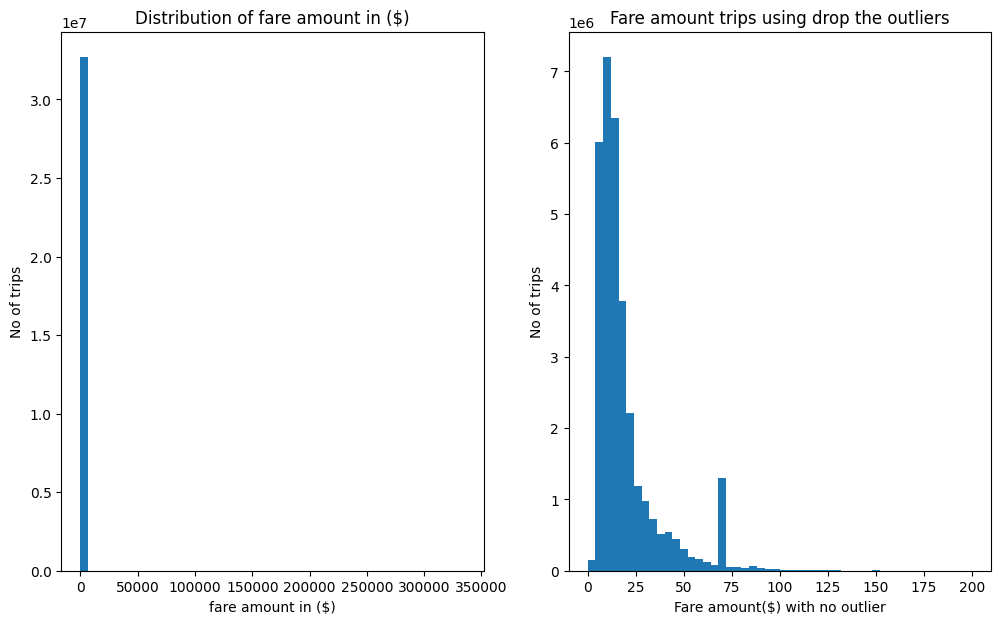

In [12]:
# filter outliers for fare_amount
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(12, 7))
#Plotting histogram
plt.subplot(121)
plt.hist(df['fare_amount'],bins=50)
plt.xlabel('fare amount in ($)')
plt.ylabel('No of trips')
plt.title('Distribution of fare amount in ($)');

#Plotting histogram with a log transformation
plt.subplot(122)

#drop the outliers, keep trips with only fare_amount < 200
df= df[df['fare_amount']<200]

plt.hist(df['fare_amount'],bins=50)
plt.xlabel('Fare amount($) with no outlier')
plt.ylabel('No of trips')
plt.title('Fare amount trips using drop the outliers');


In [17]:
# convert to log-normal
import math
df['fare_amount']=[math.log(i) for i in df['fare_amount'].values]

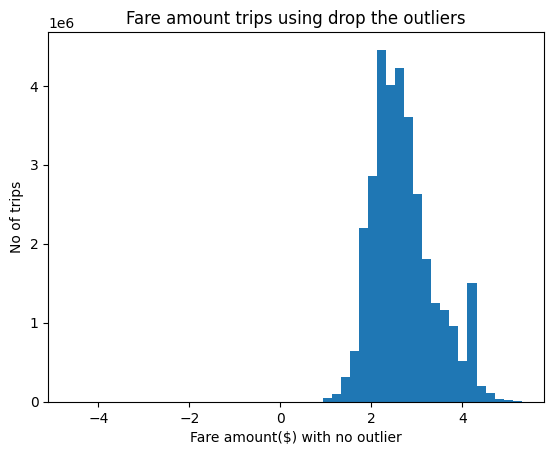

In [18]:

plt.hist(df['fare_amount'],bins=50)
plt.xlabel('Fare amount($) with no outlier')
plt.ylabel('No of trips')
plt.title('Fare amount trips using drop the outliers');


In [19]:
print("the length of trip data after dropping outliers of fare_amount: ", len(df))

the length of trip data after dropping outliers of fare_amount:  32660474


#### drop the outliers of trip_distance. only keep trip_distance<50

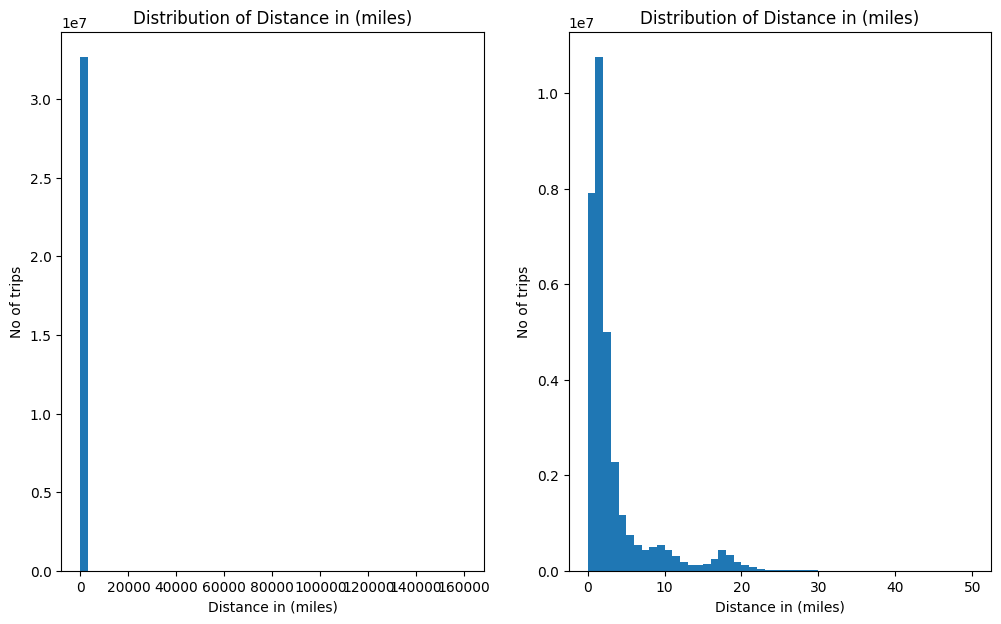

In [20]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(12, 7))
#Plotting histogram
plt.subplot(121)
plt.hist(df['trip_distance'],bins=50)
plt.xlabel('Distance in (miles)')
plt.ylabel('No of trips')
plt.title('Distribution of Distance in (miles)');

#Plotting histogram with a log transformation
plt.subplot(122)

#drop the outliers of trip_distance. only keep trip_distance<50
df= df[df['trip_distance']<50]

plt.hist(df['trip_distance'],bins=50)
plt.xlabel('Distance in (miles)')
plt.ylabel('No of trips')
plt.title('Distribution of Distance in (miles)');


In [24]:
# convert to log-normal

import math
df['trip_distance']=[math.log(i) for i in df['trip_distance'].values]

C:\Users\liche\AppData\Local\Temp\ipykernel_20232\2115718024.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trip_distance']=[math.log(i) for i in df['trip_distance'].values]


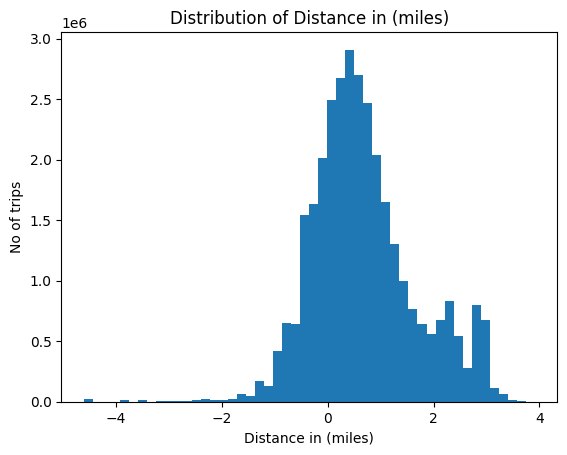

In [25]:
plt.hist(df['trip_distance'],bins=50)
plt.xlabel('Distance in (miles)')
plt.ylabel('No of trips')
plt.title('Distribution of Distance in (miles)');

In [26]:
print("the length of trip data after dropping outliers of trip_distance: ", len(df))

the length of trip data after dropping outliers of trip_distance:  32659737


In [7]:
# based on the analysis above, we write the function of cleaning data
def clean_data(df):

    len_df = len(df)
    print("the length of the initial trip data: ", len_df)

    # remove rows with nan passenger_count 
    df = df[~df['passenger_count'].isna()]
    print("the length of trip data after removing nan passenger_count: ", len(df))
    
    df.drop_duplicates(inplace=True)
    print('the length of trip data after removig duplicate rows : ', len(df))

    df = df[(df['PULocationID']!=264) & (df['PULocationID']!=265)]
    print('the length of trip data after filtering out PULocationID=264 or 265: ', len(df))

    # # Removing trips with invalid distances or negative fares
    df = df[(df['trip_distance'] > 0) & (df['trip_distance'] < 50) & (df['fare_amount']<200) & (df['fare_amount'] > 0) & (df['total_amount'] > 0)]
    print('the length of trip data after cleaning trip_distance, fare_amount and total_amount: ', len(df))

    return df
    

In [8]:
# handle the preprocessing by spliting them into chunks

chunk_size = 1_00_000  # Adjust based on available memory

# Split df_left into chunks
chunks = np.array_split(df, len(df) // chunk_size + 1)
# release memory
del df
# Perform the left join for each chunk
result_chunks = []

for chunk in chunks:
    
    result_chunks.append(clean_data(chunk))

# Concatenate all the merged chunks into the final DataFrame
df = pd.concat(result_chunks)

del chunks
del result_chunks

print("the final length of trip data: ", len(df))

C:\Users\liche\anaconda3\envs\MLops\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


the length of the initial trip data:  99738
the length of trip data after removing nan passenger_count:  99738
the length of trip data after removig duplicate rows :  99738
the length of trip data after filtering out PULocationID=264 or 265:  99231
the length of trip data after cleaning trip_distance, fare_amount and total_amount:  96077
the length of the initial trip data:  99738
the length of trip data after removing nan passenger_count:  99738
the length of trip data after removig duplicate rows :  99738
the length of trip data after filtering out PULocationID=264 or 265:  99276
the length of trip data after cleaning trip_distance, fare_amount and total_amount:  96398
the length of the initial trip data:  99738
the length of trip data after removing nan passenger_count:  99738
the length of trip data after removig duplicate rows :  99738
the length of trip data after filtering out PULocationID=264 or 265:  99312
the length of trip data after cleaning trip_distance, fare_amount and t

C:\Users\liche\AppData\Local\Temp\ipykernel_29220\977583151.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(inplace=True)


the length of trip data after filtering out PULocationID=264 or 265:  31725
the length of trip data after cleaning trip_distance, fare_amount and total_amount:  31035
the length of the initial trip data:  99738
the length of trip data after removing nan passenger_count:  27516
the length of trip data after removig duplicate rows :  27516
the length of trip data after filtering out PULocationID=264 or 265:  27406
the length of trip data after cleaning trip_distance, fare_amount and total_amount:  26779
the length of the initial trip data:  99738
the length of trip data after removing nan passenger_count:  99738
the length of trip data after removig duplicate rows :  99738
the length of trip data after filtering out PULocationID=264 or 265:  99334
the length of trip data after cleaning trip_distance, fare_amount and total_amount:  97039
the length of the initial trip data:  99738
the length of trip data after removing nan passenger_count:  99738
the length of trip data after removig dupl

In [268]:
# import pickle
# with open("initialData.pkl", "wb") as file:
#     pickle.dump(df, file)

import pickle
with open("initialData.pkl", "rb") as file:
    df = pickle.load(file)

In [269]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


## Time based features

In [13]:
df['date'] = df['tpep_pickup_datetime'].dt.date
df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['tpep_pickup_datetime'].dt.hour
df['day_of_week'] = df['tpep_pickup_datetime'].dt.dayofweek
df['day'] = df['tpep_pickup_datetime'].dt.day
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['is_rush_hour'] = df['hour'].isin([17, 18]).astype(int)  # Rush hours
df['is_idle_hour'] = df['hour'].isin([3, 4, 5]).astype(int)  # Idle hours
df['month'] = df['tpep_pickup_datetime'].dt.month
ny_holidays = set(holidays.US(years=2024, state='NY'))

# Use numpy vectorized approach for speed
df['is_holiday'] = np.where(df['date'].isin(ny_holidays), 1, 0)

C:\Users\liche\AppData\Local\Temp\ipykernel_29220\1298118966.py:13: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_holiday'] = np.where(df['date'].isin(ny_holidays), 1, 0)


In [30]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,Airport_fee,date,hour,day_of_week,day,is_weekend,is_rush_hour,is_idle_hour,month,is_holiday
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,0.542324,1.0,N,186,79,2,...,0.0,2024-01-01,0,0,1,0,0,0,1,1
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,0.587787,1.0,N,140,236,1,...,0.0,2024-01-01,0,0,1,0,0,0,1,1
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,1.547563,1.0,N,236,79,1,...,0.0,2024-01-01,0,0,1,0,0,0,1,1
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,0.336472,1.0,N,79,211,1,...,0.0,2024-01-01,0,0,1,0,0,0,1,1
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,-0.223144,1.0,N,211,148,1,...,0.0,2024-01-01,0,0,1,0,0,0,1,1


## Data Visualization and Analysis

<Axes: title={'center': 'Hourly Ride Demand'}, xlabel='hour'>

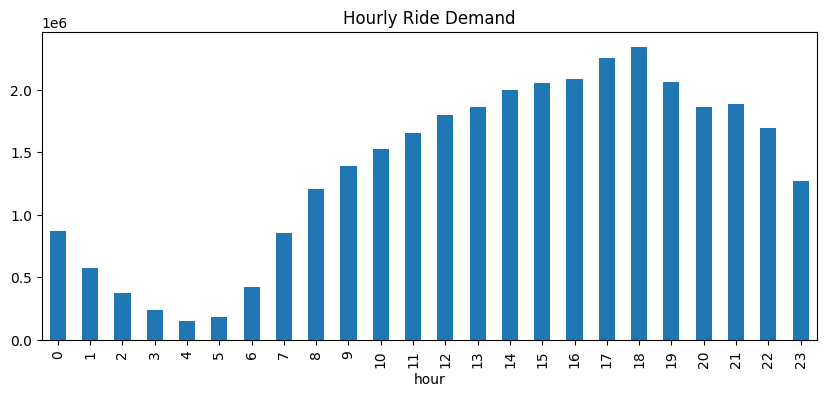

In [14]:
# find out which hours are peak demanded
hourly_demand = df.groupby('hour').size()
hourly_demand.plot(kind='bar', title="Hourly Ride Demand", figsize=(10,4))

##### hour 17, 18 are peak hours, 3, 4, 5 are off-peak hours

<Axes: title={'center': 'Day-of-Week Ride Demand'}, xlabel='day_of_week'>

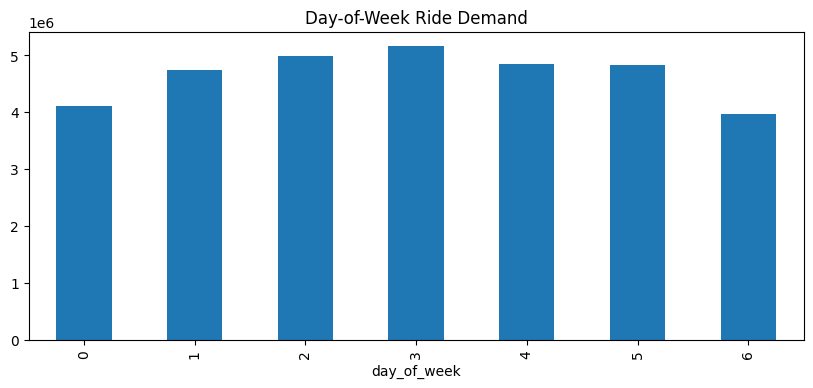

In [15]:
daily_demand = df.groupby('day_of_week').size()
daily_demand.plot(kind='bar', title="Day-of-Week Ride Demand", figsize=(10,4))

<Axes: title={'center': 'Month Ride Demand'}, xlabel='month'>

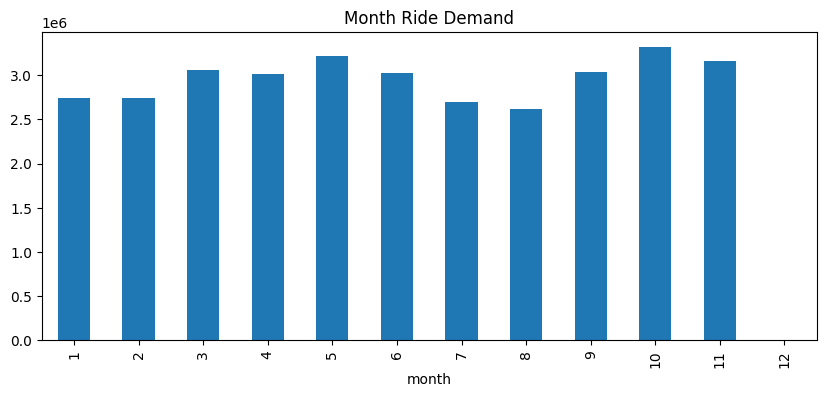

In [16]:
month_demand = df.groupby('month').size()
month_demand.plot(kind='bar', title="Month Ride Demand", figsize=(10,4))

<Axes: title={'center': 'day Ride Demand'}, xlabel='day'>

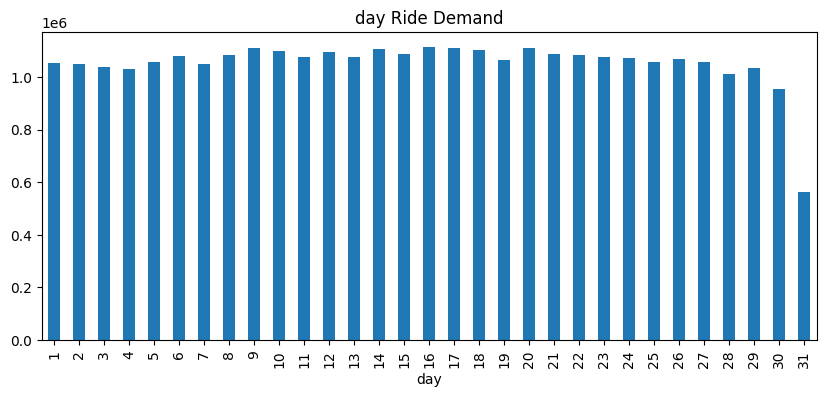

In [17]:
day_demand = df.groupby('day').size()
day_demand.plot(kind='bar', title="day Ride Demand", figsize=(10,4))

<Axes: title={'center': 'Average Demands for Holiday'}, xlabel='is_holiday'>

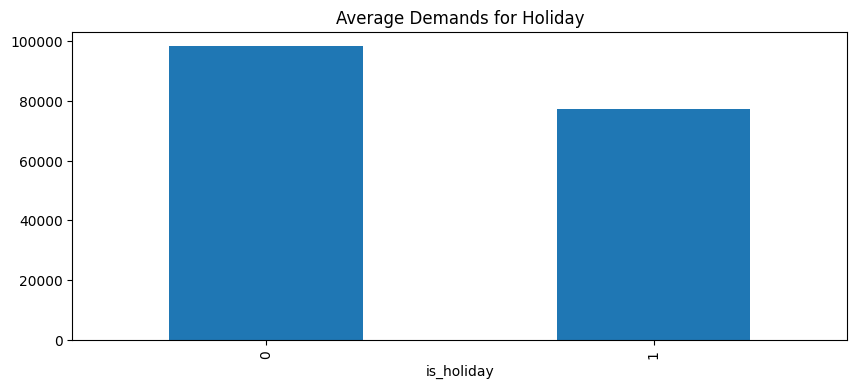

In [18]:
holidy_demand = df.groupby(['is_holiday']).size()
holidy_demand = holidy_demand /np.array([335-len(ny_holidays)+1, len(ny_holidays)-1])
holidy_demand.plot(kind='bar', title="Average Demands for Holiday", figsize=(10,4))

<Axes: title={'center': 'Hourly Ride Demand for PULocationID==1'}, xlabel='hour'>

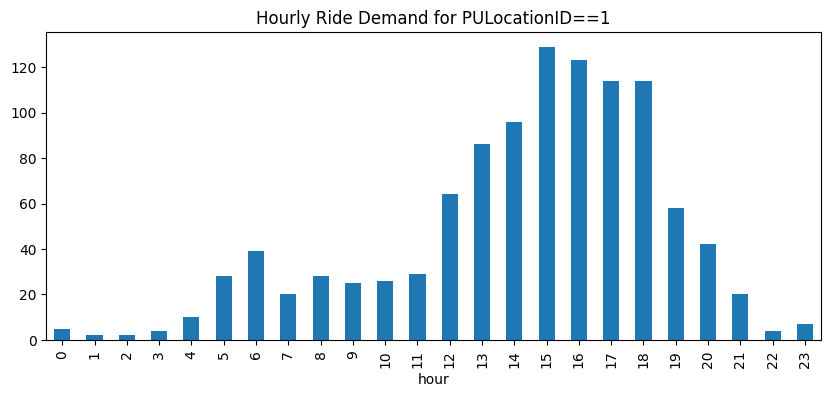

In [35]:
hourly_demand = df[df['PULocationID']==1].groupby(['hour']).size()
hourly_demand.plot(kind='bar', title="Hourly Ride Demand for PULocationID==1", figsize=(10,4))

<Axes: title={'center': 'Hourly Ride Demand for PULocationID==7'}, xlabel='hour'>

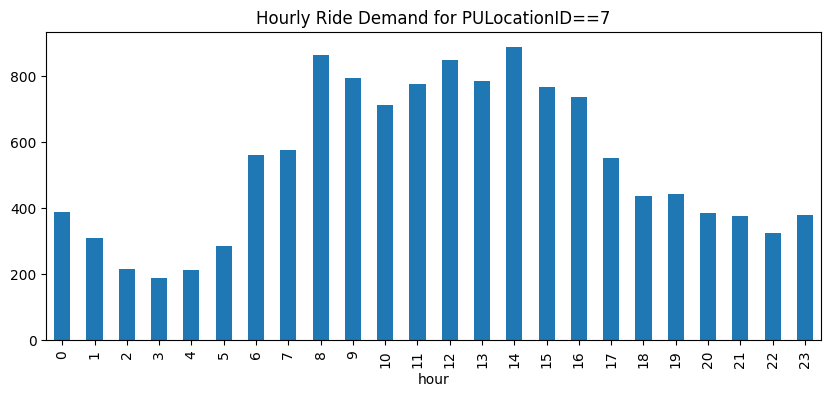

In [36]:
hourly_demand = df[df['PULocationID']==7].groupby(['hour']).size()
hourly_demand.plot(kind='bar', title="Hourly Ride Demand for PULocationID==7", figsize=(10,4))

<Axes: title={'center': 'Hourly Ride Demand for PULocationID==132'}, xlabel='hour'>

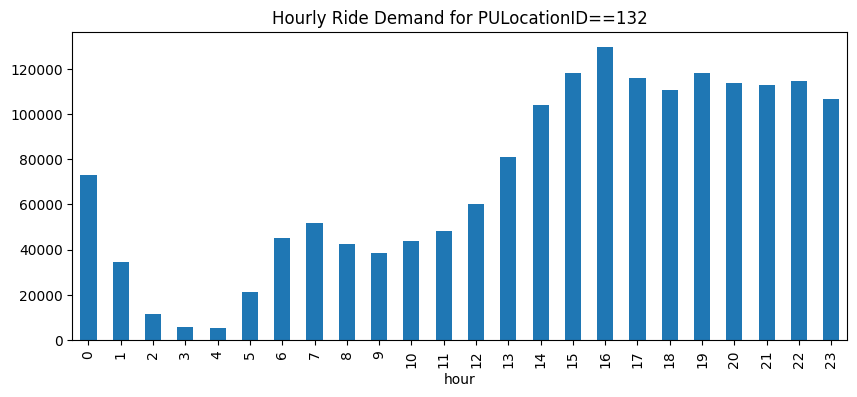

In [37]:
hourly_demand = df[df['PULocationID']==132].groupby(['hour']).size()
hourly_demand.plot(kind='bar', title="Hourly Ride Demand for PULocationID==132", figsize=(10,4))

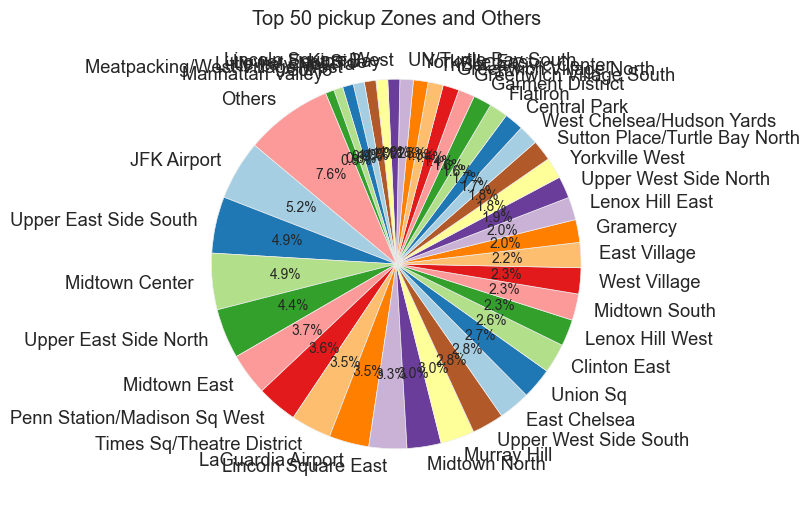

In [355]:
# show most pickup passenger zones
PULocationIDCount = df.groupby('PULocationID').size().sort_values(ascending=False)

# Sort values in descending order
sorted_percentages = PULocationIDCount.values

# Select top 10 values
topn = 40
top_10_values = sorted_percentages[:topn]

# Sum the rest into "Other"
other_value = np.sum(sorted_percentages[topn:])

# Labels for the pie chart
labels = PULocationIDCount.index[0:topn]

df_ZonesMap = pd.read_csv('taxi_zone_lookup.csv')

text_labels = df_ZonesMap.set_index('LocationID').reindex(PULocationIDCount.index[0:topn])['Zone'].values.tolist()

# text_labels =  df_ZonesMap[df_ZonesMap['LocationID'].isin(PULocationIDCount.index[0:topn])]['Zone'].values.tolist()

text_labels = text_labels + ['Others']

# Combine values (top 10 + other)
values = np.append(top_10_values, other_value)

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(values, labels=text_labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title("Top 50 pickup Zones and Others")
plt.show()


In [294]:
# most pickup region and zone
import draw
import importlib
# Make changes to my_module.py externally, then run:
importlib.reload(draw)
from draw import *

In [287]:
import shapefile
from pyproj import Transformer

sf = shapefile.Reader("taxi_zones2/taxi_zones.shp")
fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf, shp_dic).set_index("LocationID"), on="LocationID")


# Define transformer: EPSG:2263 (NY State Plane) → EPSG:4326 (WGS84)
transformer = Transformer.from_crs("EPSG:2263", "EPSG:4326", always_xy=True)

df_loc[['longitude', 'latitude']] = df_loc.apply(
    lambda row: transformer.transform(row['longitude'], row['latitude']), axis=1, result_type='expand'
)


In [361]:
# most pick up zones 

PULocationIDCount = df.groupby('PULocationID').agg( PUcount=('PULocationID', 'count'),
                                                    fare_amount=('fare_amount', 'mean')).sort_values(by=['PUcount'], ascending=False)
PULocationIDCount.reset_index('PULocationID', inplace=True)
PULocationIDCount.rename(columns={"PULocationID": "LocationID"}, inplace=True)

loc = df_loc[["LocationID", "zone", "borough"]]

df_q1 = PULocationIDCount.merge(loc, left_on="LocationID", right_on="LocationID")

PUcount = dict(zip(df_q1['LocationID'].tolist(), df_q1['PUcount'].tolist()))
PUtop10 = df_q1.sort_values(by=['PUcount'], ascending=False).set_index("LocationID").head(10)

C:\Users\liche\anaconda3\envs\MLops\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


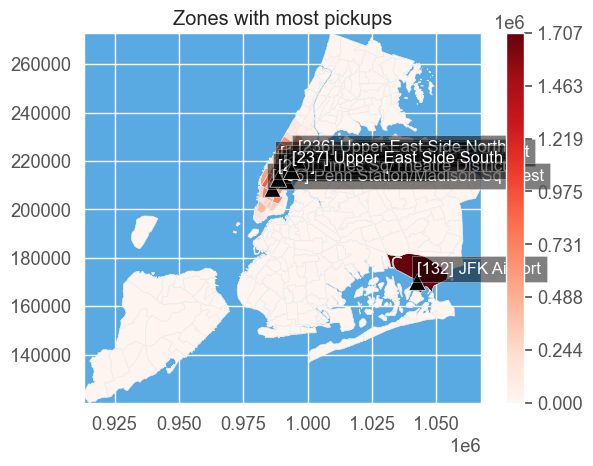

In [362]:

plt.plot(figsize=(9,8))
ax = plt.gca() 
ax.set_title("Zones with most pickups")
draw_zone_map(ax, sf, shp_dic, heat=PUcount, text=PUtop10.index.tolist())

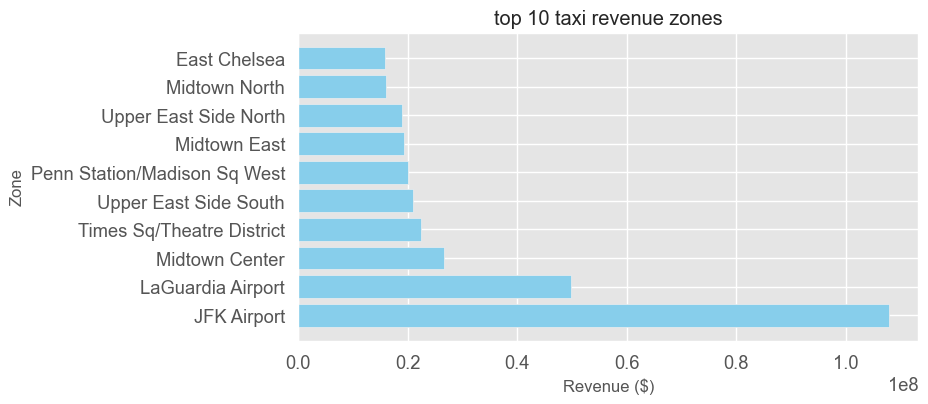

In [398]:
# top 10 higest fare amount
PULocationIDCount = df.groupby('PULocationID').agg( PUcount=('PULocationID', 'count'),
                                                    fare_amount=('fare_amount', 'mean')).sort_values(by=['fare_amount'], ascending=False)
PULocationIDCount.reset_index('PULocationID', inplace=True)
PULocationIDCount.rename(columns={"PULocationID": "LocationID"}, inplace=True)

PULocationIDCount['revenue'] = PULocationIDCount['PUcount']  * PULocationIDCount['fare_amount']  

PULocationIDCount.sort_values(by=['revenue'], ascending=False, inplace=True)

loc = df_loc[["LocationID", "zone", "borough"]]

df_q1 = PULocationIDCount.merge(loc, left_on="LocationID", right_on="LocationID")

FareAmount = dict(zip(df_q1['zone'].tolist(), df_q1['revenue'].tolist()))

first_three = dict(list(FareAmount.items())[:10])

# Create the bar plot
plt.figure(figsize=(8, 4))
plt.barh([key for key in first_three.keys()], [v for v in first_three.values()], color='skyblue')
# plt.xticks(rotation = 90)
plt.ylabel("Zone")
plt.xlabel("Revenue ($)")
plt.title("top 10 taxi revenue zones")
plt.show()


##  Construct relevant features for previous hours

In [20]:
df_aggregated = df.groupby(['PULocationID', 'month', 'day', 'hour']).agg(
    current_trips=('PULocationID', 'count'),
    total_passengers=('passenger_count', 'sum'),
    Airport_fee = ('Airport_fee', 'mean'),
    is_holiday = ('is_holiday', 'mean'),
    is_weekend = ('is_weekend', 'mean'),
    is_rush_hour=('is_rush_hour', 'mean'),
    is_idle_hour=('is_idle_hour', 'mean'),
    day_of_week = ('day_of_week', 'mean'), 
    trip_distance = ('trip_distance', 'mean'), 
    fare_amount = ('fare_amount', 'mean')
)
df_aggregated = df_aggregated.reset_index()
df_aggregated.head()

,PULocationID,month,day,hour,current_trips,total_passengers,Airport_fee,is_holiday,is_weekend,is_rush_hour,is_idle_hour,day_of_week,trip_distance,fare_amount
0,1,1,1,6,1,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.06,89.0
1,1,1,1,14,1,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.01,20.0
2,1,1,1,16,1,5.0,0.0,1.0,0.0,0.0,0.0,0.0,17.00,118.0
3,1,1,1,17,2,3.0,0.0,1.0,0.0,1.0,0.0,0.0,0.03,85.0
4,1,1,2,18,1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,2.00,9.0


In [40]:
# previous hour demand can significantly affect the current hour's demand
# Demand Persistence → If demand was high in the previous hour, it's likely to remain high in the next hour (e.g., rush hour, events).
# Spillover Effect → If taxis were unavailable in the previous hour due to high demand, some trips may shift to the next hour.
# Traffic & Delays → High demand in one hour can cause delays in pickups for the next hour, affecting availability.

# accumulate trip over previous 1h, 2h, 3h, 6h, 12h, 24h


# ✅ Add a fixed year (e.g., 2024) and convert to datetime
df_aggregated['timestamp'] = pd.to_datetime(df_aggregated.assign(year=2024)[['year', 'month', 'day', 'hour']])

# ✅ Sort by location and timestamp for correct time-based calculations
df_aggregated = df_aggregated.sort_values(by=['PULocationID', 'timestamp']).set_index('timestamp')

windows = [1, 2, 3, 6, 12, 24]

df_aggregated['distance_sum'] = df_aggregated['trip_distance'] * df_aggregated['current_trips']
df_aggregated['fare_sum'] = df_aggregated['fare_amount'] * df_aggregated['current_trips']

for window in windows:
   
        df_aggregated[f'prev_{window}h_trips'] = df_aggregated.groupby('PULocationID')['current_trips'].rolling(f'{window}h',closed='left').sum().values
        
        df_aggregated[f'prev_{window}h_passengers'] = df_aggregated.groupby('PULocationID')['total_passengers'].rolling(f'{window}h', closed='left').sum().values

        df_aggregated[f'prev_{window}h_avg_trip_distance'] = df_aggregated.groupby('PULocationID')['distance_sum'].rolling(f'{window}h',closed='left').sum().values / df_aggregated[f'prev_{window}h_trips']

        df_aggregated[f'prev_{window}h_avg_fare_amount'] = df_aggregated.groupby('PULocationID')['fare_sum'].rolling(f'{window}h',closed='left').sum().values / df_aggregated[f'prev_{window}h_trips']

df_aggregated = df_aggregated[['PULocationID', 'month', 'day', 'hour', 'current_trips', 
         'prev_1h_trips', 'prev_2h_trips', 'prev_3h_trips', 'prev_6h_trips', 'prev_12h_trips', 'prev_24h_trips', 
         'prev_1h_passengers', 'prev_2h_passengers', 'prev_3h_passengers', 'prev_6h_passengers', 'prev_12h_passengers', 'prev_24h_passengers', 
         'prev_1h_avg_trip_distance', 'prev_2h_avg_trip_distance', 'prev_3h_avg_trip_distance', 'prev_6h_avg_trip_distance', 'prev_12h_avg_trip_distance', 'prev_24h_avg_trip_distance',
         'prev_1h_avg_fare_amount', 'prev_2h_avg_fare_amount', 'prev_3h_avg_fare_amount', 'prev_6h_avg_fare_amount', 'prev_12h_avg_fare_amount', 'prev_24h_avg_fare_amount', 
          'is_holiday' , 'is_weekend' , 'is_rush_hour', 'is_idle_hour', 'day_of_week']]


df_aggregated.fillna(0, inplace=True)

df_aggregated.head()

,PULocationID,month,day,hour,current_trips,prev_1h_trips,prev_2h_trips,prev_3h_trips,prev_6h_trips,prev_12h_trips,...,prev_2h_avg_fare_amount,prev_3h_avg_fare_amount,prev_6h_avg_fare_amount,prev_12h_avg_fare_amount,prev_24h_avg_fare_amount,is_holiday,is_weekend,is_rush_hour,is_idle_hour,day_of_week
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-01-01 06:00:00,1,1,1,6,1,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0
2024-01-01 14:00:00,1,1,1,14,1,0.0,0.0,0.0,0.0,1.0,...,0.000000,0.000000,0.000000,4.488636,4.488636,1.0,0.0,0.0,0.0,0.0
2024-01-01 16:00:00,1,1,1,16,1,0.0,1.0,1.0,1.0,2.0,...,2.995732,2.995732,2.995732,3.742184,3.742184,1.0,0.0,0.0,0.0,0.0
2024-01-01 17:00:00,1,1,1,17,2,1.0,1.0,2.0,2.0,3.0,...,4.770685,3.883208,3.883208,4.085018,4.085018,1.0,0.0,1.0,0.0,0.0
2024-01-02 18:00:00,1,1,2,18,1,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0,1.0


In [41]:
print('the length of trip data after restructure: ', len(df_aggregated))

the length of trip data after restructure:  796735


## Combine Location based features 

In [43]:
import shapefile
from pyproj import Transformer

sf = shapefile.Reader("taxi_zones2/taxi_zones.shp")
fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf, shap_dic).set_index("LocationID"), on="LocationID")


# Define transformer: EPSG:2263 (NY State Plane) → EPSG:4326 (WGS84)
transformer = Transformer.from_crs("EPSG:2263", "EPSG:4326", always_xy=True)

df_loc[['longitude', 'latitude']] = df_loc.apply(
    lambda row: transformer.transform(row['longitude'], row['latitude']), axis=1, result_type='expand'
)

df_loc

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,-74.171526,40.689488
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,-73.822490,40.610791
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,-73.844947,40.865745
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,-73.977726,40.724137
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,-74.187537,40.550665
...,...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,-73.856319,40.899070
259,260,0.133514,0.000422,Woodside,260,Queens,-73.906841,40.746605
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,-74.012644,40.709120
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,-73.945142,40.776681


In [44]:
df_ZonesLookup = pd.read_csv('taxi_zone_lookup.csv')

In [45]:
df_ZonesLookup.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [46]:
df_ZonesMap = df_loc.merge(df_ZonesLookup[['LocationID', 'service_zone']], on='LocationID')
df_ZonesMap.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude,service_zone
0,1,0.116357,0.000782,Newark Airport,1,EWR,-74.171526,40.689488,EWR
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,-73.822490,40.610791,Boro Zone
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,-73.844947,40.865745,Boro Zone
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,-73.977726,40.724137,Yellow Zone
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,-74.187537,40.550665,Boro Zone


In [47]:

label_encoder = LabelEncoder()

# Apply label encoding to categorical columns
df_ZonesMap['borough'] = label_encoder.fit_transform(df_ZonesMap['borough'])
borough_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("\nBorough Label Encoding Mapping:")
print(borough_mapping)



Borough Label Encoding Mapping:
{'Bronx': 0, 'Brooklyn': 1, 'EWR': 2, 'Manhattan': 3, 'Queens': 4, 'Staten Island': 5}


In [48]:
label_encoder = LabelEncoder()
df_ZonesMap['zone'] = label_encoder.fit_transform(df_ZonesMap['zone'])
Zone_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("\nZone Label Encoding Mapping:")
print(Zone_mapping)


Zone Label Encoding Mapping:
{'Allerton/Pelham Gardens': 0, 'Alphabet City': 1, 'Arden Heights': 2, 'Arrochar/Fort Wadsworth': 3, 'Astoria': 4, 'Astoria Park': 5, 'Auburndale': 6, 'Baisley Park': 7, 'Bath Beach': 8, 'Battery Park': 9, 'Battery Park City': 10, 'Bay Ridge': 11, 'Bay Terrace/Fort Totten': 12, 'Bayside': 13, 'Bedford': 14, 'Bedford Park': 15, 'Bellerose': 16, 'Belmont': 17, 'Bensonhurst East': 18, 'Bensonhurst West': 19, 'Bloomfield/Emerson Hill': 20, 'Bloomingdale': 21, 'Boerum Hill': 22, 'Borough Park': 23, 'Breezy Point/Fort Tilden/Riis Beach': 24, 'Briarwood/Jamaica Hills': 25, 'Brighton Beach': 26, 'Broad Channel': 27, 'Bronx Park': 28, 'Bronxdale': 29, 'Brooklyn Heights': 30, 'Brooklyn Navy Yard': 31, 'Brownsville': 32, 'Bushwick North': 33, 'Bushwick South': 34, 'Cambria Heights': 35, 'Canarsie': 36, 'Carroll Gardens': 37, 'Central Harlem': 38, 'Central Harlem North': 39, 'Central Park': 40, 'Charleston/Tottenville': 41, 'Chinatown': 42, 'City Island': 43, 'Claremo

In [49]:
label_encoder = LabelEncoder()
df_ZonesMap['service_zone'] = label_encoder.fit_transform(df_ZonesMap['service_zone'])
service_zone_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("\nservice_zone Label Encoding Mapping:")
print(service_zone_mapping)


service_zone Label Encoding Mapping:
{'Airports': 0, 'Boro Zone': 1, 'EWR': 2, 'Yellow Zone': 3}


In [50]:
df_ZonesMap.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude,service_zone
0,1,0.116357,0.000782,168,1,2,-74.171526,40.689488,2
1,2,0.433470,0.004866,126,2,4,-73.822490,40.610791,1
2,3,0.084341,0.000314,0,3,0,-73.844947,40.865745,1
3,4,0.043567,0.000112,1,4,3,-73.977726,40.724137,3
4,5,0.092146,0.000498,2,5,5,-74.187537,40.550665,1


In [51]:
# combined time based features and location based features
chunk_size = 1_00_000  # Adjust based on available memory

# Split df_left into chunks
chunks = np.array_split(df_aggregated, len(df_aggregated) // chunk_size + 1)
# release memory
del df
# Perform the left join for each chunk
result_chunks = []

for chunk in chunks:
    merged_chunk = chunk.merge(df_ZonesMap[['zone',	'LocationID', 'borough', 'longitude',  'latitude', 'service_zone']], left_on="PULocationID", right_on="LocationID", how="left")
    result_chunks.append(merged_chunk)

# Concatenate all the merged chunks into the final DataFrame
df_merged = pd.concat(result_chunks)

# Reset index if needed
df_merged.reset_index(drop=True, inplace=True)

del chunks

C:\Users\liche\anaconda3\envs\MLops\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [52]:
df_merged.head()

,PULocationID,month,day,hour,current_trips,prev_1h_trips,prev_2h_trips,prev_3h_trips,prev_6h_trips,prev_12h_trips,...,is_weekend,is_rush_hour,is_idle_hour,day_of_week,zone,LocationID,borough,longitude,latitude,service_zone
0,1,1,1,6,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,168.0,1.0,2.0,-74.171526,40.689488,2.0
1,1,1,1,14,1,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,168.0,1.0,2.0,-74.171526,40.689488,2.0
2,1,1,1,16,1,0.0,1.0,1.0,1.0,2.0,...,0.0,0.0,0.0,0.0,168.0,1.0,2.0,-74.171526,40.689488,2.0
3,1,1,1,17,2,1.0,1.0,2.0,2.0,3.0,...,0.0,1.0,0.0,0.0,168.0,1.0,2.0,-74.171526,40.689488,2.0
4,1,1,2,18,1,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,168.0,1.0,2.0,-74.171526,40.689488,2.0


In [53]:
df_merged = df_merged.dropna()

In [2]:
# import pickle
# with open("Cleaned Data.pkl", "wb") as file:
#     pickle.dump(df_merged, file)

import pickle
with open("Cleaned Data.pkl", "rb") as file:
    df_merged = pickle.load(file)

In [3]:
df_merged.isna().sum()

PULocationID                  0
month                         0
day                           0
hour                          0
current_trips                 0
prev_1h_trips                 0
prev_2h_trips                 0
prev_3h_trips                 0
prev_6h_trips                 0
prev_12h_trips                0
prev_24h_trips                0
prev_1h_passengers            0
prev_2h_passengers            0
prev_3h_passengers            0
prev_6h_passengers            0
prev_12h_passengers           0
prev_24h_passengers           0
prev_1h_avg_trip_distance     0
prev_2h_avg_trip_distance     0
prev_3h_avg_trip_distance     0
prev_6h_avg_trip_distance     0
prev_12h_avg_trip_distance    0
prev_24h_avg_trip_distance    0
prev_1h_avg_fare_amount       0
prev_2h_avg_fare_amount       0
prev_3h_avg_fare_amount       0
prev_6h_avg_fare_amount       0
prev_12h_avg_fare_amount      0
prev_24h_avg_fare_amount      0
is_holiday                    0
is_weekend                    0
is_rush_

## Feature engineering 

In [ ]:
# Final Feature Selection for Demand Forecasting
# ✅ Keep (Most Important)
# Time Features: tpep_pickup_datetime (hour, day, weekday, weekend, rush hour, holiday)
# Location Features: PULocationID (pickup zones)
# External Data (Optional): Weather, events

# ⚠️ Maybe (Secondary Features)
# trip_distance, total_amount (to check if high fares impact demand)

# ❌ Drop (Not Useful for Demand)
# VendorID, store_and_fwd_flag, payment_type, RatecodeID, and all fare/tip/tax-related features.

### Correlation Matrix

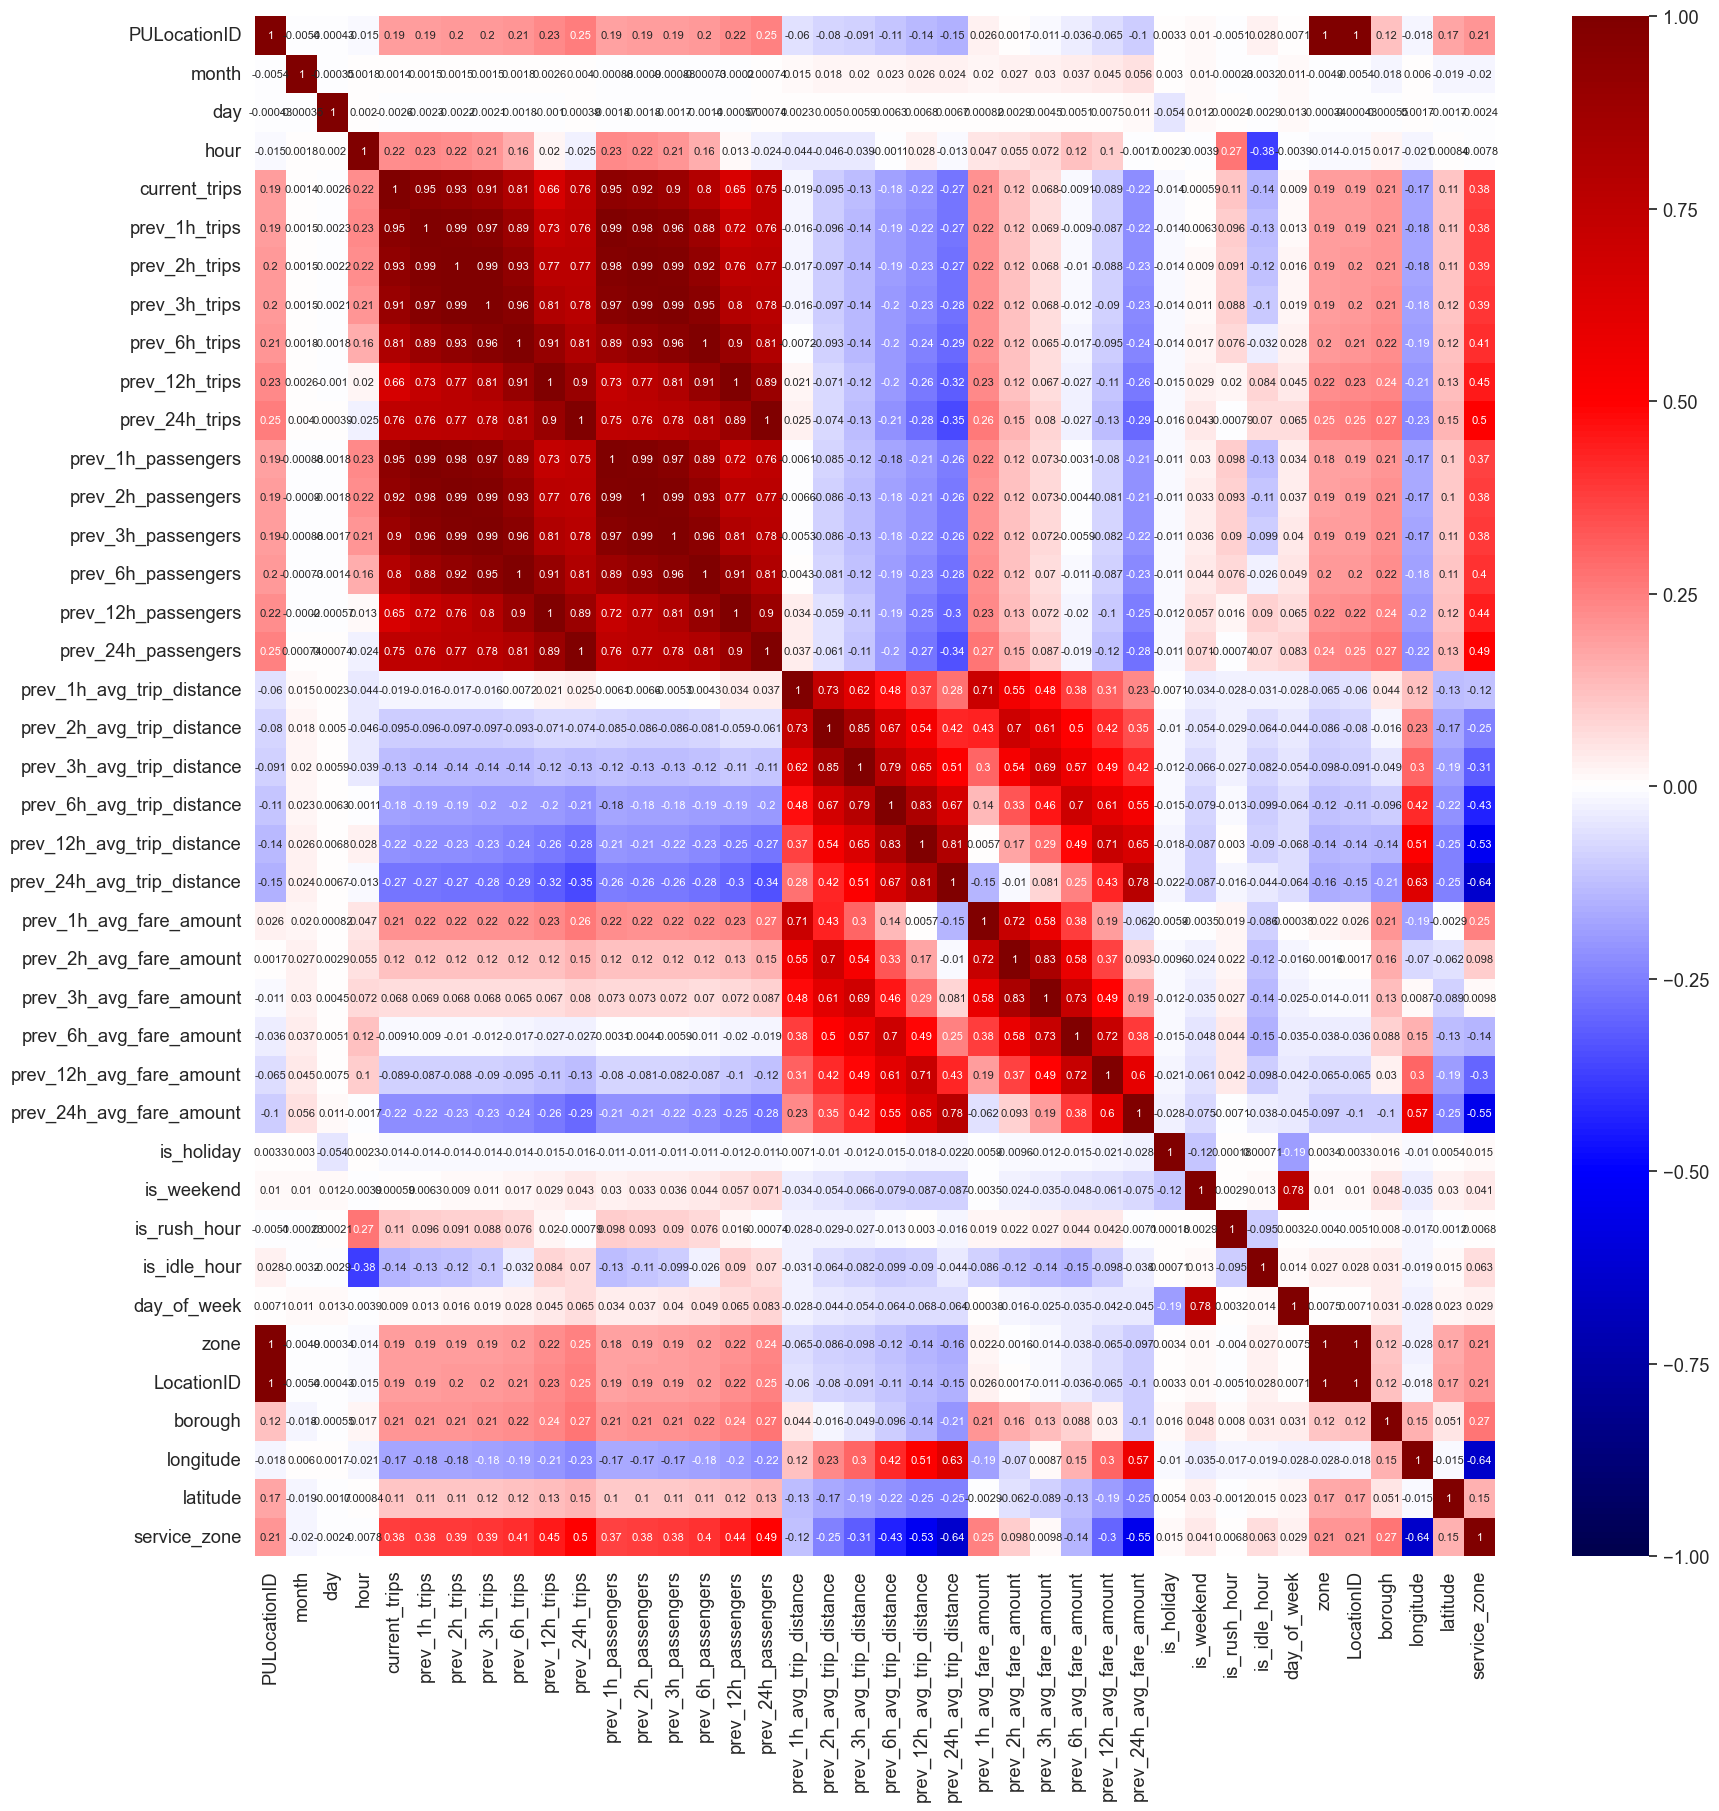

In [23]:
#Corr matrix for whole df features
import seaborn as sns
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(df_merged.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1, annot_kws={"size":8});

In [4]:
# we select 'longitude', 'latitude', 'borough', 'service_zone', 'current_trips', 'prev_1h_trips',  'prev_2h_trips',  'prev_6h_trips'
# number of passengers is high correlated with number of trips. So that we do not need features about number of passengers
# a high fare may indicate a high demand. 
df_select=df_merged.loc[:,['PULocationID', 'longitude', 'latitude', 'borough', 'service_zone', 'current_trips', 
         'prev_1h_trips', 'prev_2h_trips', 'prev_6h_trips', 'prev_1h_avg_fare_amount', 'prev_24h_avg_fare_amount', 'hour']]

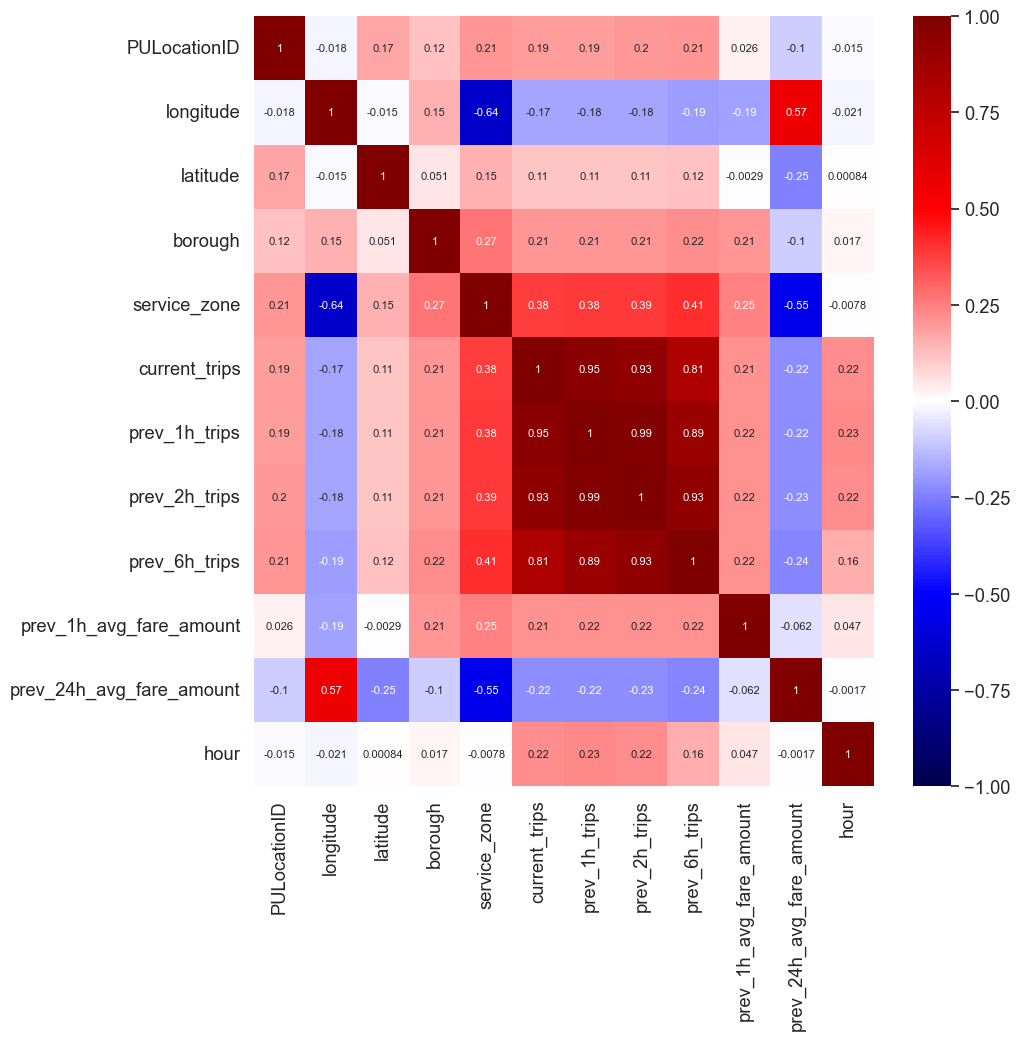

In [5]:
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(df_select.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1, annot_kws={"size":8});

## separate high demand locations and low demand locations


In [147]:
# separate high demand locations and low demand locations

# show most pickup passenger zones
sort_trips = df_merged.groupby('PULocationID').current_trips.agg('sum').sort_values()
top50Locs = sort_trips[-50:].index

In [148]:
df_high = df_merged[df_merged['PULocationID'].isin(top50Locs)]
df_high.head()
print('the length of trip data for high demand locations: ', len(df_high))

the length of trip data for high demand locations:  391281


In [149]:
df_low = df_merged[~df_merged['PULocationID'].isin(top50Locs)]
df_low.head()
print('the length of trip data for high demand locations: ', len(df_low))

the length of trip data for high demand locations:  411368


In [151]:
df_median = df_small[df_small['current_trips']<500]
print('the length of trip data with trips<500: ', len(df_median))

the length of trip data with trips<500:  801826


## split training and test

In [401]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

np.random.seed(42)


# Step 1: Split Data
train = df_select[df_merged['month'] <= 8]  # Training (First 8 months)
valid = df_select[(df_merged['month'] > 8) & (df_merged['month'] <= 10)]  # Validation (9th and 10th month)
holdout = df_select[df_merged['month'] >= 11]  # Holdout (Final month)

X_train, y_train = train.drop(columns=['current_trips', 'PULocationID']), train['current_trips']
X_valid, y_valid = valid.drop(columns=['current_trips', 'PULocationID']), valid['current_trips']
X_holdout, y_holdout = holdout.drop(columns=['current_trips', 'PULocationID']), holdout['current_trips']

# Step 2: Define Time Series Cross-Validation 
tscv = TimeSeriesSplit(n_splits=3)

In [402]:
train.head()

,PULocationID,longitude,latitude,borough,service_zone,current_trips,prev_1h_trips,prev_2h_trips,prev_6h_trips,prev_1h_avg_fare_amount,prev_24h_avg_fare_amount,hour
0,1,-74.171526,40.689488,2.0,2.0,1,0.0,0.0,0.0,0.000000,0.000000,6
1,1,-74.171526,40.689488,2.0,2.0,1,0.0,0.0,0.0,0.000000,4.488636,14
2,1,-74.171526,40.689488,2.0,2.0,1,0.0,1.0,1.0,0.000000,3.742184,16
3,1,-74.171526,40.689488,2.0,2.0,2,1.0,1.0,2.0,4.770685,4.085018,17
4,1,-74.171526,40.689488,2.0,2.0,1,0.0,0.0,0.0,0.000000,0.000000,18


### Random forest

In [8]:
# random forest

# Step 3: Define Random Forest Model & Parameter Grid
rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [20, 50],  # Fewer trees for quick training
    # 'max_depth': [5, 10],  # Limit tree depth
    # 'min_samples_split': [2, 5]  # Minimum samples per split
}

# # Step 4: Perform Grid Search with Time Series Cross-Validation
# grid_search = GridSearchCV(rf, param_grid, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
# grid_search.fit(X_train, y_train)

# # Step 5: Get Best Parameters and Train Final Model
# best_params = grid_search.best_params_
# print(f'Best Parameters: {best_params}')

# best_rf = RandomForestRegressor(**best_params, random_state=42)
best_rf = RandomForestRegressor(random_state=42, n_estimators=200, max_samples=0.01)
best_rf.fit(X_train, y_train)

# Step 6: Evaluate on Validation Set
y_pred_valid = best_rf.predict(X_valid)
valid_mae = mean_absolute_error(y_valid, y_pred_valid)
valid_mape = mean_absolute_percentage_error(y_valid, y_pred_valid)
valid_r2 = r2_score(y_valid, y_pred_valid)
print(f'Validation MAE with RF: {valid_mae}')
print(f'Validation MAPE with RF: {valid_mape}')
print(f'Validation R2 with RF: {valid_r2}')

# Step 7: Evaluate on Holdout Set
y_pred_holdout = best_rf.predict(X_holdout)
holdout_mae = mean_absolute_error(y_holdout, y_pred_holdout)
holdout_mape = mean_absolute_percentage_error(y_holdout, y_pred_holdout)
holdout_r2 = r2_score(y_holdout, y_pred_holdout)
print(f'Holdout Test MAE: {holdout_mae}')
print(f'Holdout Test MAPE: {holdout_mape}')
print(f'holdout R2 with RF: {holdout_r2}')

Validation MAE with RF: 7.605639933858353
Validation MAPE with RF: 0.46210164217703087
Validation R2 with RF: 0.948676043611211
Holdout Test MAE: 7.985180212541004
Holdout Test MAPE: 0.48091622347042956
holdout R2 with RF: 0.9415238260082421


In [ ]:
import shap
# Create a SHAP Explainer
explainer = shap.TreeExplainer(best_rf)

# Compute SHAP Values (for a sample of test data)
shap_values = explainer.shap_values(X_valid)

shap.summary_plot(shap_values[1], X_valid, plot_type="bar")

In [ ]:
# 
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
import re

# Create a sample DataFrame with synthetic data
np.random.seed(42)

# Train a RandomForestClassifier on the training data


# Initialize the LIME Tabular Explainer using training data
explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    mode='regression',
)

# 5. Compute LIME explanations for a sample of test instances and aggregate feature importances
feature_importance = {fname: [] for fname in X_train.columns}

def extract_base_feature(feature_str):
    """
    Extracts the base feature name from a string.
    Handles strings like:
      - "feature1 <= 0.47"         -> returns "feature1"
      - "prev_1h_trips <= 1.00"      -> returns "prev_1h_trips"
      - "7.00 < hour <= 12.00"       -> returns "hour"
    """
    # First, try to extract everything before the first comparison operator.
    pattern_initial = r"^(.*?)\s*(<=|>=|<|>|==)"
    match = re.match(pattern_initial, feature_str)
    if match:
        candidate = match.group(1).strip()
        # If candidate is numeric, then we need to extract the word in the middle.
        try:
            float(candidate)  # If conversion succeeds, candidate is numeric.
            # Use a fallback pattern: look for a word that follows a '<'
            pattern_fallback = r"<\s*([A-Za-z_]\w*)\s*(<=|<|>|>=)"
            match_fallback = re.search(pattern_fallback, feature_str)
            if match_fallback:
                return match_fallback.group(1)
            else:
                # Fallback not found, return candidate (though likely numeric)
                return candidate
        except ValueError:
            # Candidate is not numeric, so return it.
            return candidate
    else:
        # If no match, simply split by whitespace and return the first token.
        return feature_str.split()[0]

for idx in range(len(X_valid)):
    instance = X_valid.iloc[idx,:]
    # Explain instance; use all features for explanation (num_features = total number of features)
    exp = explainer.explain_instance(data_row=instance, predict_fn=best_rf.predict, num_features=len(X_train.columns))
    # exp.as_list() returns list of tuples: (feature condition string, weight)
    print(exp.as_list())
    for feature_str, weight in exp.as_list():
        # Extract the base feature name. LIME returns strings like "feature1 <= 0.47" or "feature2 > 7.33"
      
        base_feature = extract_base_feature(feature_str)
        feature_importance[base_feature].append(abs(weight))

# 6. Aggregate the absolute weights (average over the sampled instances)
global_importance = {feature: np.mean(weights) if len(weights) > 0 else 0 for feature, weights in feature_importance.items()}

# Convert to DataFrame for visualization
importance_df = pd.DataFrame.from_dict(global_importance, orient='index', columns=['Avg Abs Weight'])
importance_df.sort_values(by='Avg Abs Weight', ascending=False, inplace=True)

# Print the aggregated feature importances
print("Aggregated Global Feature Importance from LIME:")
print(importance_df)

# 7. Plot the aggregated global feature importance
importance_df.plot(kind='bar', figsize=(8, 5))
plt.ylabel("Average Absolute Weight (LIME)")
plt.title("Global Feature Importance Approximation via LIME")
plt.tight_layout()
plt.show()



## xgboost

In [229]:
import xgboost as xgb

# Load the diabetes dataset (a regression dataset)

# Create DMatrix objects for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)
dholdout = xgb.DMatrix(X_holdout, label=y_holdout)

# Define hyperparameters for regression
params = {
    'objective': 'reg:squarederror',  # regression with squared error loss
    'max_depth': 4,                   # maximum tree depth
    'eta': 0.1,                       # learning rate
    'subsample': 0.8,                 # subsample ratio of the training instances
    'colsample_bytree': 0.8,          # subsample ratio of columns when constructing each tree
    'seed': 42                        # random seed for reproducibility
}

num_round = 1000  # number of boosting rounds

# Train the XGBoost model
model = xgb.train(params, dtrain, num_round)

# Predict on the validation and holdout set
y_pred_valid = model.predict(dvalid)
y_pred_train = model.predict(dtrain)
# Evaluate the model using Mean Squared Error (MSE)

valid_mae = mean_absolute_error(y_valid, y_pred_valid)
valid_mape = mean_absolute_percentage_error(y_valid, y_pred_valid)
valid_r2 = r2_score(y_valid, y_pred_valid)
print(f'Validation MAE with xgboost: {valid_mae}')
print(f'Validation MAPE with xgboost: {valid_mape}')
print(f'Validation R2 with xgboost: {valid_r2}')

# Step 7: Evaluate on Holdout Set
y_pred_holdout = model.predict(dholdout)
holdout_mae = mean_absolute_error(y_holdout, y_pred_holdout)
holdout_mape = mean_absolute_percentage_error(y_holdout, y_pred_holdout)
holdout_r2 = r2_score(y_holdout, y_pred_holdout)
print(f'Holdout Test MAE with xgboost: {holdout_mae}')
print(f'Holdout Test MAPE with xgboost: {holdout_mape}')
print(f'holdout R2 with xgboost: {holdout_r2}')


Validation MAE with xgboost: 6.850683503831432
Validation MAPE with xgboost: 0.46613096289181477
Validation R2 with xgboost: 0.9636302697410448
Holdout Test MAE with xgboost: 7.2162610576817565
Holdout Test MAPE with xgboost: 0.4899224106136417
holdout R2 with xgboost: 0.9578600800786001


## Feature importance

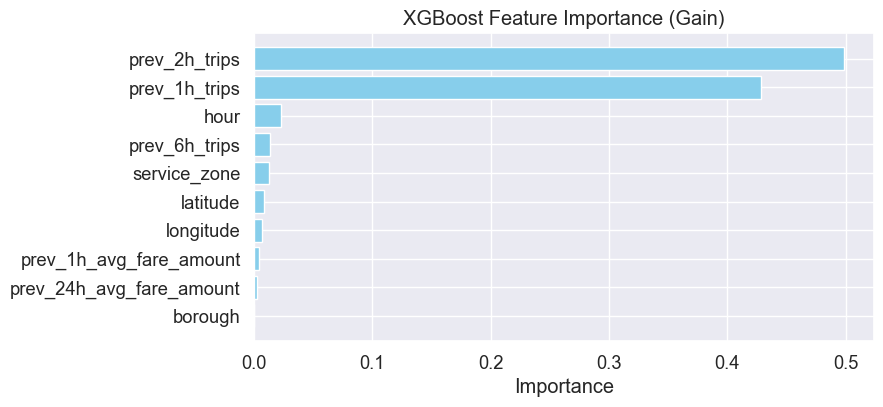

In [239]:
# Retrieve feature importance using the 'gain' metric.
importance = model.get_score(importance_type='gain')

# Convert the dictionary into a DataFrame.
importance_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'Gain'])

# Sort the DataFrame so that the most important features are at the top.
importance_df.sort_values(by='Gain', ascending=False, inplace=True)

# Plot a horizontal bar chart.
plt.figure(figsize=(8, 4))
plt.barh(importance_df['Feature'], importance_df['Gain']/importance_df['Gain'].sum(), color='skyblue')
plt.xlabel("Importance")
plt.title("XGBoost Feature Importance (Gain)")
plt.gca().invert_yaxis()  # Invert y-axis to display the highest importance at the top
plt.show()

In [ ]:
import shap
# Create a SHAP Explainer
explainer = shap.TreeExplainer(xgb)

# Compute SHAP Values (for a sample of test data)
shap_values = explainer.shap_values(X_valid)

shap.summary_plot(shap_values[1], X_valid, plot_type="bar")

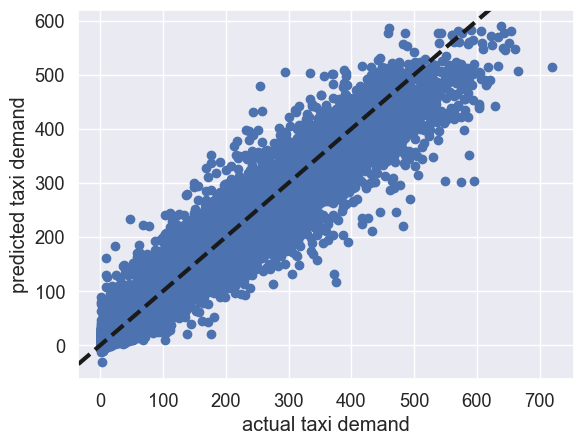

In [234]:
# the relationship between groundtruth and prediction
plt.scatter(y_valid, y_pred_valid)
plt.xlabel('actual taxi demand')
plt.ylabel('predicted taxi demand')
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

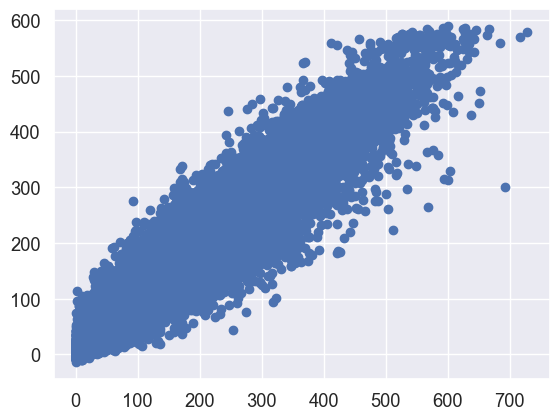

In [231]:
plt.scatter(y_train, y_pred_train)

Text(0, 0.5, 'number of trips')

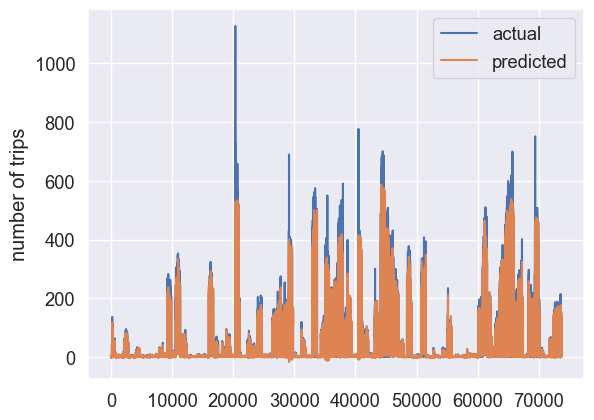

In [263]:
plt.plot(np.arange(len(y_holdout)), y_holdout, y_pred_holdout, '-')
plt.legend(['actual', 'predicted'])
plt.ylabel('number of trips')

In [403]:
train.head()

,PULocationID,longitude,latitude,borough,service_zone,current_trips,prev_1h_trips,prev_2h_trips,prev_6h_trips,prev_1h_avg_fare_amount,prev_24h_avg_fare_amount,hour
0,1,-74.171526,40.689488,2.0,2.0,1,0.0,0.0,0.0,0.000000,0.000000,6
1,1,-74.171526,40.689488,2.0,2.0,1,0.0,0.0,0.0,0.000000,4.488636,14
2,1,-74.171526,40.689488,2.0,2.0,1,0.0,1.0,1.0,0.000000,3.742184,16
3,1,-74.171526,40.689488,2.0,2.0,2,1.0,1.0,2.0,4.770685,4.085018,17
4,1,-74.171526,40.689488,2.0,2.0,1,0.0,0.0,0.0,0.000000,0.000000,18


In [404]:
dftrain = df_merged[df_merged['month'] <= 8]  # Training (First 8 months)
dfvalid = df_merged[(df_merged['month'] > 8) & (df_merged['month'] <= 10)]  # Validation (9th and 10th month)
dfholdout = df_merged[df_merged['month'] >= 11]  # Holdout (Final month)


In [426]:
# PULocationIDCount = df.groupby('PULocationID').agg( PUcount=('PULocationID', 'count'),
#                                                     fare_amount=('fare_amount', 'mean')).sort_values(by=['fare_amount'], ascending=False)
# PULocationIDCount.reset_index('PULocationID', inplace=True)
# PULocationIDCount.rename(columns={"PULocationID": "LocationID"}, inplace=True)

def StreamlitOutput(df, y, PULocationIDCount):
    df = df.loc[:,['PULocationID', 'month', 'day', 'hour', 'current_trips', 'borough', 'service_zone', 'longitude', 'latitude']]
    y[y<0] = 0
    df['predict_trips'] = y
    df = df.merge(PULocationIDCount[['LocationID', 'fare_amount']], left_on='PULocationID', right_on='LocationID', how='left')
    return df
    

In [433]:
df_valid_pred = StreamlitOutput(dfvalid, y_pred_valid, PULocationIDCount)
df_holdout_pred = StreamlitOutput(dfholdout, y_pred_holdout, PULocationIDCount)

In [434]:
df_holdout_pred.head()

,PULocationID,month,day,hour,current_trips,borough,service_zone,longitude,latitude,predict_trips,LocationID,fare_amount
0,1,11,1,18,1,2.0,2.0,-74.171526,40.689488,1.560403,1,77.673879
1,1,11,1,22,1,2.0,2.0,-74.171526,40.689488,0.000000,1,77.673879
2,1,11,2,6,1,2.0,2.0,-74.171526,40.689488,1.055515,1,77.673879
3,1,11,2,9,1,2.0,2.0,-74.171526,40.689488,2.118706,1,77.673879
4,1,11,2,18,1,2.0,2.0,-74.171526,40.689488,1.129497,1,77.673879


In [436]:
df_pred = pd.concat([df_valid_pred, df_holdout_pred])

df_pred.to_csv('PredictedTrips.csv', index=False)  

In [437]:
df_pred.head()

,PULocationID,month,day,hour,current_trips,borough,service_zone,longitude,latitude,predict_trips,LocationID,fare_amount
0,1,9,1,8,1,2.0,2.0,-74.171526,40.689488,1.888714,1,77.673879
1,1,9,1,10,1,2.0,2.0,-74.171526,40.689488,2.023626,1,77.673879
2,1,9,1,11,1,2.0,2.0,-74.171526,40.689488,2.656342,1,77.673879
3,1,9,1,20,1,2.0,2.0,-74.171526,40.689488,0.000000,1,77.673879
4,1,9,2,4,1,2.0,2.0,-74.171526,40.689488,0.071749,1,77.673879


### MLP

In [146]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

def preprocess_features(df):
    """
    Preprocess all features including one-hot encoding and cyclical encoding
    
    Parameters:
    df: DataFrame with the taxi data
    
    Returns:
    processed_df: DataFrame with processed features
    encoders: Dict of fitted encoders for categorical features
    """
    df = df.copy()
    
    # Cyclical encoding for hours
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
    
    # One-hot encoding for categorical features
    categorical_features = ['borough', 'service_zone']
    encoders = {}
    
    for feature in categorical_features:
        encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
        encoded_features = encoder.fit_transform(df[[feature]])
        
        # Create column names for encoded features
        feature_names = [f"{feature}_{val}" for val in encoder.categories_[0]]
        
        # Add encoded features to dataframe
        encoded_df = pd.DataFrame(encoded_features, columns=feature_names, index=df.index)
        df = pd.concat([df, encoded_df], axis=1)
        
        # Store encoder for future use
        encoders[feature] = encoder
        
        # Drop original categorical column
        df = df.drop(columns=[feature])
    
    return df, encoders

def prepare_mlp_data(df):
    """
    Prepare data for MLP model
    
    Parameters:
    df: DataFrame with the taxi data
    
    Returns:
    X: Input features
    y: Target values
    scalers: Dict of scalers for each feature
    encoders: Dict of encoders for categorical features
    """
    # Preprocess categorical features
    df_processed, encoders = preprocess_features(df)
    
    # Define feature groups
    geo_features = ['longitude', 'latitude']
 
    numeric_features = [
        'prev_1h_trips', 'prev_2h_trips', 'prev_6h_trips', 
        'prev_1h_avg_fare_amount', 'prev_24h_avg_fare_amount', 
    ]
    
    # Get one-hot encoded column names
    categorical_cols = [col for col in df_processed.columns 
                       if col.startswith(('borough_', 'service_zone_'))]
    
    # Initialize scalers
    scalers = {}
    
    # Special scaler for geographical coordinates
    geo_scaler = MinMaxScaler()
    geo_features_scaled = geo_scaler.fit_transform(df_processed[geo_features])
    scalers['geo'] = geo_scaler
    
    # Scale numeric features
    X = pd.DataFrame()
    
    # Add scaled geographic features
    for i, feature in enumerate(geo_features):
        X[feature] = geo_features_scaled[:, i]
    
    # Scale other numeric features
    for col in numeric_features:
        if col in df_processed.columns:  # Check if column exists
            
            scaler = MinMaxScaler()
            X[col] = scaler.fit_transform(df_processed[[col]])
            scalers[col] = scaler
    
    # Add categorical features (already one-hot encoded, no scaling needed)
    print(categorical_cols)
    for col in categorical_cols:
        X[col] = df_processed[col].values
    # Scale target
    target_scaler = MinMaxScaler()
    y = target_scaler.fit_transform(df_processed[['current_trips']])
    scalers['target'] = target_scaler

    print(X.columns)

    return X.values, y, scalers, encoders, X.columns, X

def create_mlp_model(n_features):
    """
    Create MLP model for trip prediction
    """
    model = Sequential([
        Dense(64, activation='relu', input_shape=(n_features,)),
        BatchNormalization(),
        Dropout(0.5),
        
        # Dense(64, activation='relu'),
        # # BatchNormalization(),
        # Dropout(0.2),
        
        Dense(32, activation='relu'),
        # BatchNormalization(),
        Dropout(0.1),
        
        Dense(1)
    ])
    
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )
    
    return model

def train_model(df, epochs=50, batch_size=32):
    """
    Train MLP model on the taxi data
    """
    # Prepare data

    X, y, scalers, encoders, _, _ = prepare_mlp_data(df)
    
    # Step 1: Split training, validation and holdout
    X_train, y_train = X[df_merged['month'] <= 8, :], y[df_merged['month'] <= 8]
    X_valid, y_valid =  X[(df_merged['month'] > 8) & (df_merged['month'] <= 10), :], y[(df_merged['month'] > 8) & (df_merged['month'] <= 10)]
    X_holdout, y_holdout =  X[df_merged['month'] >= 11, :], y[df_merged['month'] >= 11]

    print('the size of X_train: ', X_train.shape[0])
    print('the size of X_valid: ', X_valid.shape[0])
    print('the size of X_holdout: ', X_holdout.shape[0])
    print("the max and min of y_train", np.max(y_train), np.min(y_train))
    
    # Create and train model
    model = create_mlp_model(X.shape[1])
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            )
        ]
    )
    
    return model, scalers, encoders, history, X_valid, y_valid, X_holdout, y_holdout

def predict_trips(model, scalers, encoders, new_data):
    """
    Make predictions using the trained model
    """
    # Preprocess new data
    new_data_processed, _ = preprocess_features(new_data.copy())
    
    # Prepare features in the same way as training data
    X_pred = pd.DataFrame()
    
    # Handle geographic features
    geo_features = ['longitude', 'latitude']
    geo_scaled = scalers['geo'].transform(new_data_processed[geo_features])
    for i, feature in enumerate(geo_features):
        X_pred[feature] = geo_scaled[:, i]
    
    # Handle numeric features
    for col in scalers:
        if col not in ['geo', 'target'] and col in new_data_processed.columns:
            X_pred[col] = scalers[col].transform(new_data_processed[[col]])
    
    # Add categorical features (already one-hot encoded)
    categorical_cols = [col for col in new_data_processed.columns 
                       if col.startswith(('borough_', 'service_zone_'))]
    for col in categorical_cols:
        X_pred[col] = new_data_processed[col]
    
    # Make prediction and inverse transform
    prediction = model.predict(X_pred.values)
    prediction = scalers['target'].inverse_transform(prediction)
    
    return prediction.flatten()


model, scalers, encoders, history, X_valid, y_valid, X_holdout, y_holdout = train_model(df_select)

target_scaler  = scalers['target']


# Evaluate the model using Mean Squared Error (MSE)

prediction = model.predict(X_valid)
valid_mae = mean_absolute_error(target_scaler.inverse_transform(y_valid), target_scaler.inverse_transform(prediction))
valid_mape = mean_absolute_percentage_error(target_scaler.inverse_transform(y_valid), target_scaler.inverse_transform(prediction))
valid_r2 = r2_score(target_scaler.inverse_transform(y_valid), target_scaler.inverse_transform(prediction))
print(f'Validation MAE with MLP: {valid_mae}')
print(f'Validation MAPE with MLP: {valid_mape}')
print(f'Validation R2 with MLP: {valid_r2}')

# Step 7: Evaluate on Holdout Set
prediction = model.predict(X_holdout)
holdout_mae = mean_absolute_error(target_scaler.inverse_transform(y_holdout), target_scaler.inverse_transform(prediction))
holdout_mape = mean_absolute_percentage_error(target_scaler.inverse_transform(y_holdout), target_scaler.inverse_transform(prediction))
holdout_r2 = r2_score(target_scaler.inverse_transform(y_holdout), target_scaler.inverse_transform(prediction))
print(f'Holdout MAE with MLP: {holdout_mae}')
print(f'Holdout MAPE with MLP: {holdout_mape}')
print(f'holdout R2 with MLP: {holdout_r2}')


C:\Users\liche\anaconda3\envs\MLops\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\liche\anaconda3\envs\MLops\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


['borough_0.0', 'borough_1.0', 'borough_2.0', 'borough_3.0', 'borough_4.0', 'borough_5.0', 'service_zone_0.0', 'service_zone_1.0', 'service_zone_2.0', 'service_zone_3.0']
Index(['longitude', 'latitude', 'prev_1h_trips', 'prev_2h_trips',
       'prev_6h_trips', 'prev_1h_avg_fare_amount', 'prev_24h_avg_fare_amount',
       'borough_0.0', 'borough_1.0', 'borough_2.0', 'borough_3.0',
       'borough_4.0', 'borough_5.0', 'service_zone_0.0', 'service_zone_1.0',
       'service_zone_2.0', 'service_zone_3.0'],
      dtype='object')
the size of X_train:  579801
the size of X_valid:  149074
the size of X_holdout:  73774
the max and min of y_train 0.6462222222222223 0.0
Epoch 1/50


C:\Users\liche\anaconda3\envs\MLops\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18119/18119 ━━━━━━━━━━━━━━━━━━━━ 47s 3ms/step - loss: 0.0326 - mae: 0.0709 - val_loss: 5.2777e-04 - val_mae: 0.0118
Epoch 2/50
18119/18119 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - loss: 6.7571e-04 - mae: 0.0151 - val_loss: 5.0347e-04 - val_mae: 0.0133
Epoch 3/50
18119/18119 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step - loss: 6.3873e-04 - mae: 0.0144 - val_loss: 5.2887e-04 - val_mae: 0.0150
Epoch 4/50
18119/18119 ━━━━━━━━━━━━━━━━━━━━ 48s 3ms/step - loss: 6.2564e-04 - mae: 0.0141 - val_loss: 5.8331e-04 - val_mae: 0.0158
Epoch 5/50
18119/18119 ━━━━━━━━━━━━━━━━━━━━ 49s 3ms/step - loss: 6.0820e-04 - mae: 0.0139 - val_loss: 6.0672e-04 - val_mae: 0.0175
Epoch 6/50
18119/18119 ━━━━━━━━━━━━━━━━━━━━ 49s 3ms/step - loss: 6.0457e-04 - mae: 0.0139 - val_loss: 8.0693e-04 - val_mae: 0.0191
Epoch 7/50
18119/18119 ━━━━━━━━━━━━━━━━━━━━ 48s 3ms/step - loss: 5.9934e-04 - mae: 0.0138 - val_loss: 6.9558e-04 - val_mae: 0.0169
4659/4659 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation MAE with MLP: 14.931049992010719
Validation 

##  LSTM

In [56]:
df_lstm = df_merged.loc[:,['PULocationID', 'longitude', 'latitude', 'borough', 'service_zone', 'current_trips', 
         'prev_1h_trips', 'prev_2h_trips', 'prev_6h_trips', 'prev_1h_avg_fare_amount', 'prev_24h_avg_fare_amount', 'hour', 'month', 'day']]

In [152]:
class FeaturePreprocessor:
    """
    Handle feature preprocessing and scaling for LSTM model
    """
    def __init__(self):
        self.trip_scaler = MinMaxScaler()  # For trip-related features
        self.fare_scaler = StandardScaler()  # For fare-related features
        
    def fit(self, df):
        """Fit scalers on training data"""
        # Scale trip-related features
        trip_features = ['current_trips', 'prev_1h_trips', 'prev_2h_trips', 'prev_6h_trips', 'longitude', 'latitude']
        self.trip_scaler.fit(df[trip_features])
        
        # Scale fare-related features
        fare_features = ['prev_1h_avg_fare_amount', 'prev_24h_avg_fare_amount']
        self.fare_scaler.fit(df[fare_features])
        
    def transform_features(self, df):
        """Transform features using fitted scalers"""
        df_scaled = df.copy()
        
        # Transform trip-related features
        trip_features = ['current_trips', 'prev_1h_trips', 'prev_2h_trips', 'prev_6h_trips', 'longitude', 'latitude']
        df_scaled[trip_features] = self.trip_scaler.transform(df[trip_features])
        
        # Transform fare-related features
        fare_features = ['prev_1h_avg_fare_amount', 'prev_24h_avg_fare_amount']
        df_scaled[fare_features] = self.fare_scaler.transform(df[fare_features])
        
        # One-hot encode categorical variables
        df_scaled = pd.get_dummies(df_scaled, columns=['borough', 'service_zone'], drop_first=True)
        
        # Cyclical encoding for hour and month
        df_scaled['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
        df_scaled['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
        df_scaled['month_sin'] = np.sin(2 * np.pi * df['month']/12)
        df_scaled['month_cos'] = np.cos(2 * np.pi * df['month']/12)
        df_scaled['day_sin'] = np.sin(2 * np.pi * df['day']/31)
        df_scaled['day_cos'] = np.cos(2 * np.pi * df['day']/31)
        
        return df_scaled

def prepare_lstm_data(df, lookback=3, train_months=range(1,9), val_months=range(9,11), test_months=range(11,12)):
    """
    Prepare data for LSTM model with proper feature scaling
    """
    # Initialize preprocessor
    preprocessor = FeaturePreprocessor()
    
    # Sort the dataframe
    df = df.sort_values(['PULocationID', 'month', 'day', 'hour'])
    
    # Split data by months
    train_data = df[df['month'].isin(train_months)].copy()
    val_data = df[df['month'].isin(val_months)].copy()
    test_data = df[df['month'].isin(test_months)].copy()
    
    # Fit preprocessor on training data only
    preprocessor.fit(train_data)
    
    # Transform all splits
    train_scaled = preprocessor.transform_features(train_data)
    val_scaled = preprocessor.transform_features(val_data)
    test_scaled = preprocessor.transform_features(test_data)
    
    def create_sequences(data):
        features = []
        targets = []
        
        for location in data['PULocationID'].unique():
            loc_data = data[data['PULocationID'] == location]
            
            for i in range(len(loc_data) - lookback):
                seq = loc_data.iloc[i:i + lookback + 1]
                expected_hours = seq['hour'].values
                actual_hours = np.arange(seq['hour'].min(), seq['hour'].max() + 1)
                
                if np.array_equal(expected_hours, actual_hours):
                    feature_cols = [col for col in loc_data.columns if col not in ['PULocationID', 'current_trips']]
                    seq_features = seq.iloc[:lookback][feature_cols].values
                    target = seq.iloc[lookback]['current_trips']
                    
                    features.append(seq_features)
                    targets.append(target)
        
        return np.array(features), np.array(targets)
    
    # Create sequences for each split
    X_train, y_train = create_sequences(train_scaled)
    X_val, y_val = create_sequences(val_scaled)
    X_test, y_test = create_sequences(test_scaled)
    
    return X_train, y_train, X_val, y_val, X_test, y_test, preprocessor
    # return X_test, y_test, preprocessor

In [153]:
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, activation='relu', input_shape=input_shape, return_sequences=True),
        BatchNormalization(),
        Dropout(0.3),                                                                                                                                                 
        LSTM(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.005), loss='mse', metrics=['mae'])
    
    return model
    
def train_predict_trips( df, lookback=3, epochs=20, batch_size=50):
    
    X_train, y_train, X_val, y_val, X_test, y_test, preprocessor = prepare_lstm_data(df, lookback)

    X_train = np.asarray(X_train).astype(np.float32)
    y_train = np.asarray(y_train).astype(np.float32)
    X_val = np.asarray(X_val).astype(np.float32)
    y_val = np.asarray(y_val).astype(np.float32)
    X_test = np.asarray(X_test).astype(np.float32)
    y_test = np.asarray(y_test).astype(np.float32)
        
    if len(X_train) == 0:
        raise ValueError("No valid sequences were created for training.")
    
    model = create_lstm_model(input_shape=(lookback, X_train.shape[2]))
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )
    
    evaluation_metrics = {
        'train': model.evaluate(X_train, y_train, verbose=0),
        'validation': model.evaluate(X_val, y_val, verbose=0),
        'test': model.evaluate(X_test, y_test, verbose=0)
    }
    
    return model, preprocessor, history, evaluation_metrics


In [ ]:
def predict_future_trips(model, preprocessor, recent_data, location_id, month, day, hour):
    input_data = recent_data.copy()
    input_data['Month'] = month
    input_data['day'] = day
    input_data['hour'] = hour
    
    scaled_data = preprocessor.transform_features(input_data)
    
    feature_cols = [col for col in scaled_data.columns if col not in ['PULocationID', 'current_trips', 'hour', 'Month', 'day']]
    X = scaled_data[feature_cols].values.reshape(1, len(recent_data), -1)
    
    prediction = model.predict(X)[0][0]
    
    prediction = preprocessor.trip_scaler.inverse_transform([[prediction]])[0][0]
    
    return prediction


In [154]:
model, preprocessor, history, evaluation_metrics = train_predict_trips(df_lstm, epochs=30)

Epoch 1/30


C:\Users\liche\anaconda3\envs\MLops\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6427/6427 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step - loss: 0.0137 - mae: 0.0618 - val_loss: 0.0033 - val_mae: 0.0354
Epoch 2/30
6427/6427 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - loss: 0.0023 - mae: 0.0301 - val_loss: 0.0028 - val_mae: 0.0360
Epoch 3/30
6427/6427 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - loss: 0.0021 - mae: 0.0286 - val_loss: 0.0031 - val_mae: 0.0321
Epoch 4/30
6427/6427 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - loss: 0.0019 - mae: 0.0276 - val_loss: 0.0024 - val_mae: 0.0270
Epoch 5/30
6427/6427 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - loss: 0.0019 - mae: 0.0271 - val_loss: 0.0031 - val_mae: 0.0302
Epoch 6/30
6427/6427 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - loss: 0.0019 - mae: 0.0269 - val_loss: 0.0026 - val_mae: 0.0324
Epoch 7/30
6427/6427 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - loss: 0.0018 - mae: 0.0268 - val_loss: 0.0024 - val_mae: 0.0283
Epoch 8/30
6427/6427 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - loss: 0.0018 - mae: 0.0268 - val_loss: 0.0027 - val_mae: 0.0319
Epoch 9/30
6427/6427 ━━━━━━━━━━━━━━━━━━━━ 3

In [158]:
 X_train, y_train, X_val, y_val, X_test, y_test, preprocessor = prepare_lstm_data(df_lstm, 3)

In [205]:


X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
X_val = np.asarray(X_val).astype(np.float32)
y_val = np.asarray(y_val).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

prediction = model.predict(X_val)

placeholder1 = np.zeros_like(prediction) 
placeholder2 = np.zeros_like(prediction) 
placeholder3 = np.zeros_like(prediction) 
placeholder4 = np.zeros_like(prediction) 
placeholder5 = np.zeros_like(prediction) 

scaled_prediction = np.hstack([prediction, placeholder1, placeholder2, placeholder3, placeholder4, placeholder5])
prediction_original = preprocessor.trip_scaler.inverse_transform(scaled_prediction)[:,0]

scaled_val = np.hstack([y_val.reshape(-1, 1), placeholder1, placeholder2, placeholder3, placeholder4, placeholder5])
y_val_original = preprocessor.trip_scaler.inverse_transform(scaled_val)[:,0]

valid_mae = mean_absolute_error(y_val_original, prediction_original)
valid_mape = mean_absolute_percentage_error(y_val_original, prediction_original)
valid_r2 = r2_score(y_val_original, prediction_original)
print(f'Validation MAE with LSTM: {valid_mae}')
print(f'Validation MAPE with LSTM: {valid_mape}')
print(f'Validation R2 with LSTM: {valid_r2}')

prediction = model.predict(X_test)

placeholder1 = np.zeros_like(prediction) 
placeholder2 = np.zeros_like(prediction) 
placeholder3 = np.zeros_like(prediction) 
placeholder4 = np.zeros_like(prediction) 
placeholder5 = np.zeros_like(prediction) 

scaled_prediction = np.hstack([prediction, placeholder1, placeholder2, placeholder3, placeholder4, placeholder5])
prediction_holdout_original = preprocessor.trip_scaler.inverse_transform(scaled_prediction)[:,0]

scaled_holdout = np.hstack([y_test.reshape(-1, 1), placeholder1, placeholder2, placeholder3, placeholder4, placeholder5])
y_holdout_original = preprocessor.trip_scaler.inverse_transform(scaled_holdout)[:,0]

holdout_mae = mean_absolute_error(y_holdout_original, prediction_holdout_original)
holdout_mape = mean_absolute_percentage_error(y_holdout_original, prediction_holdout_original)
holdout_r2 = r2_score(y_holdout_original, prediction_holdout_original)
print(f'Holdout MAE with LSTM: {holdout_mae}')
print(f'Holdout MAPE with LSTM: {holdout_mape}')
print(f'Holdout R2 with LSTM: {holdout_r2}')



2585/2585 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Validation MAE with LSTM: 19.551048278808594
Validation MAPE with LSTM: 1.2211487293243408
Validation R2 with LSTM: 0.8619696553747999
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Holdout MAE with LSTM: 22.93221664428711
Holdout MAPE with LSTM: 1.2354950904846191
Holdout R2 with LSTM: -24.295235502729426


##  conclusion 

#### Random forest 

* Validation MAE with RF: 7.605639933858353
* Validation MAPE with RF: 0.46210164217703087
* Validation R2 with RF: 0.948676043611211
* Holdout Test MAE with RF: 7.985180212541004
* Holdout Test MAPE with RF: 0.48091622347042956
* holdout R2 with RF: 0.9415238260082421

#### XGboost
* Validation MAE with xgboost: 6.850683503831432
* Validation MAPE with xgboost: 0.46613096289181477
* Validation R2 with xgboost: 0.9636302697410448
* Holdout Test MAE with xgboost: 7.2162610576817565
* Holdout Test MAPE with xgboost: 0.4899224106136417
* holdout R2 with xgboost: 0.9578600800786001

#### MLP
* Validation MAE with MLP: 14.931049992010719
* Validation MAPE with MLP: 3.9938292564629227
* Validation R2 with MLP: 0.8929903319207773
* Holdout MAE with MLP: 15.297202148844004
* Holdout MAPE with MLP: 4.055652028059659
* holdout R2 with MLP: 0.8858378938198498

#### LSTM
* Validation MAE with LSTM: 19.551048278808594
* Validation MAPE with LSTM: 1.2211487293243408
* Validation R2 with LSTM: 0.8619696553747999
* Holdout MAE with LSTM: 22.93221664428711
* Holdout MAPE with LSTM: 1.2354950904846191
*  Holdout R2 with LSTM: -24.295235502729426

#### Conclusion
* My goal of the project is to predict hourly taxi demand for each PUlocationID. 
* XGboost performs best among four algorithms I implemented (RF, Xgboost, MLP and LSTM). Xgboost is much faster than RF, I choose xgboost as the deliverable model.
* Why xgboost performs well? The features I extracted include the trips of pervious hours. Tree based methods can also capture the time-aware features in this way.
* Time series cross validation can be used for selecting the best hyperparameters. It is slow in my PC. I have not tried it but the code is there. 
* High taxi demand also depends on the weather, event and other external factors 
* Why LSTM does not perform well in this case? 1. we may need to carefully fill the data of missing hours (forward-will or backward-will? ) 2. feature scaling is important for LSTM (such as log normal transformation). 3. model tuning 
* We need more efforts to understand the data, features and the project goals (such as, daily demand prediction? hourly demand prediction? 3-hour demand prediction?  prediciton for high demand locations? prediciton for low demand locations? ) and then choose the best model